### Poisson problem with Mixed boundary conditions

Let's solve together the following problem:
$$
\begin{cases}
\Delta u &= f, \quad \text{in $\Omega$} \\
       u &= g_D, \quad \text{over $\Gamma_D$}  \\
\nabla u \cdot \mathbf{n} &= g_N, \quad \text{over $\Gamma_N$} 
\end{cases}
$$
with $\Omega$ the usual crown section, $\Gamma_D$ and $\Gamma_N$ respectively the curved and flat borders of the domain,
$$
g_D = 0, g_N = 1
$$
and $f$ the usual function we define on this domain.

In [1]:
import numpy as np
import scipy.sparse as sps
import meshio
import matplotlib.pyplot as plt
import time

In [2]:
import myfavfunctions as mff

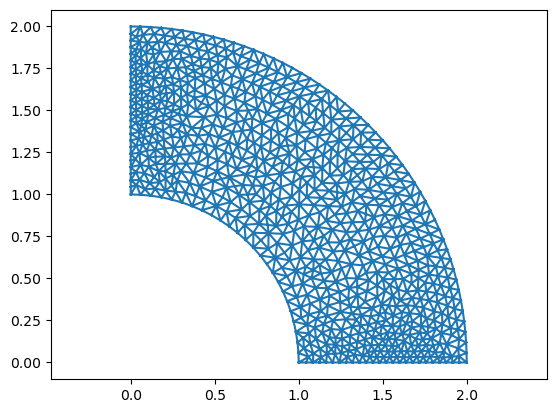

In [3]:
# mesh = meshio.read('../mesh-files/crown.vtu')
# mesh = meshio.read('../mesh-files/crown_hard.vtu')
mesh = meshio.read('../mesh-files/crown_harder.vtu')
# mesh = meshio.read('../mesh-files/crown_hardest.vtu')

%matplotlib inline
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()


Points = mesh.points[:,:2]  # for sake of brevity (had to set :2 bcause meshio is stupid or something idk)
CList  = mesh.cells[0].data # for sake of brevity
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )
iBt = np.linalg.inv( B ).transpose( (0,2,1) )

In [4]:
def fun( x ):
    r = 1
    R = 2
    z =   np.sin( np.arccos( x[:,0] / np.sqrt( np.sum( x**2,1 ) ) ) ) \
        * np.cos( np.arccos( x[:,0] / np.sqrt( np.sum( x**2,1 ) ) ) ) \
        * ( np.sqrt( np.sum( x**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( x**2,1 ) ) )
    
    return z[:,None]

g_N        = lambda x: np.ones( (x.shape[0],1) )

In [5]:
Nv = Points.shape[0]
Nc =  CList.shape[0]

# Preparation
gamma = mff.external_subsimplexes( CList )
border_vertices = np.unique( gamma )

# flat regions are neumann
region = np.empty( Nv )
region[ border_vertices ] = np.logical_or( Points[ border_vertices,0 ] < np.finfo(float).eps, \
                                           Points[ border_vertices,1 ] < np.finfo(float).eps )
gamma_N = gamma[ np.argwhere( np.prod( region[ gamma ], axis = 1 ) ).reshape(-1),: ]

# curvy regions are dirichlet
region = np.empty( Nv )
rho = np.sqrt( np.sum( Points[ border_vertices,: ]**2, axis = 1 ) )
region[ border_vertices ] = np.logical_or( rho < 1 + 0.0001, \
                                           rho > 2 - 0.0001 )
gamma_D = gamma[ np.argwhere( np.prod( region[ gamma ], axis = 1 ) ).reshape(-1),: ]
Dir = np.unique( gamma_D )

print( gamma.shape )
print( gamma_D.shape )
print( gamma_N.shape )

(125, 2)
(75, 2)
(50, 2)


In [6]:
# M = mff.mass_assembly ( Points, CList, dtB ) # not necessary
S = mff.stiff_assembly( Points, CList, dtB, iBt )

# assemble rhs
rhs = 0

# quadrature on Omega
d_elem =  CList.shape[1] - 1
X, W = mff.simplexQuadrature( 4, d_elem )
aux = np.zeros( ( Nc, CList.shape[1] ) ) # we make space for the Nc * CList.shape[1] contributions!
for q in range( W.shape[0] ):
    N0 = mff.phi( d_elem, X[q,:][None,:] )
    p = B @ X[q,:] + Points[CList[:,0]]
    aux = aux + ( fun( p ) @ N0 ) * ( dtB * W[q] )[:,None]
rhs = rhs + np.bincount( CList.reshape(-1,order='F'), aux.reshape(-1,order='F'), Nv ) 

# quadrature on Gamma_N
d_subsim   =  gamma_N.shape[1] - 1
B_subsim   = ( Points[gamma_N[:,1:]] - Points[gamma_N[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB_subsim = np.sqrt( np.linalg.det( B_subsim.transpose( 0,2,1 ) @ B_subsim ) )

X, W = mff.simplexQuadrature( 4, d_subsim )
aux = np.zeros( ( gamma_N.shape[0], gamma_N.shape[1] ) ) # we make space for the Nc * CList.shape[1] contributions!
for q in range( W.shape[0] ):
    N0 = mff.phi( d_subsim, X[q,:][None,:] )
    p = B_subsim @ X[q,:] + Points[gamma_N[:,0]]
    aux = aux + ( g_N( p ) @ N0 ) * ( dtB_subsim * W[q] )[:,None]
rhs = rhs + np.bincount( gamma_N.reshape(-1,order='F'), aux.reshape(-1,order='F'), Nv ) 

In [7]:
# Solving part :3

S_ = S.copy()
S_[ Dir,: ] = 0 # bad!!! (inefficient, if you spy this you'll find lots of present entries)
S_ = S_.tocoo()
S_.row = np.append( S_.row, Dir )
S_.col = np.append( S_.col, Dir )
S_.data = np.append( S_.data, np.ones_like( Dir ) )
S_ = S_.tocsr()
S_.eliminate_zeros()

rhs_ = rhs.copy()
rhs_[ Dir ] = 0

/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
t = time.time()
sol = sps.linalg.spsolve( - S_, rhs_ )
print('Elapsed time %1.3f seconds.' % (time.time() - t))

Elapsed time 0.014 seconds.


<IPython.core.display.Javascript object>


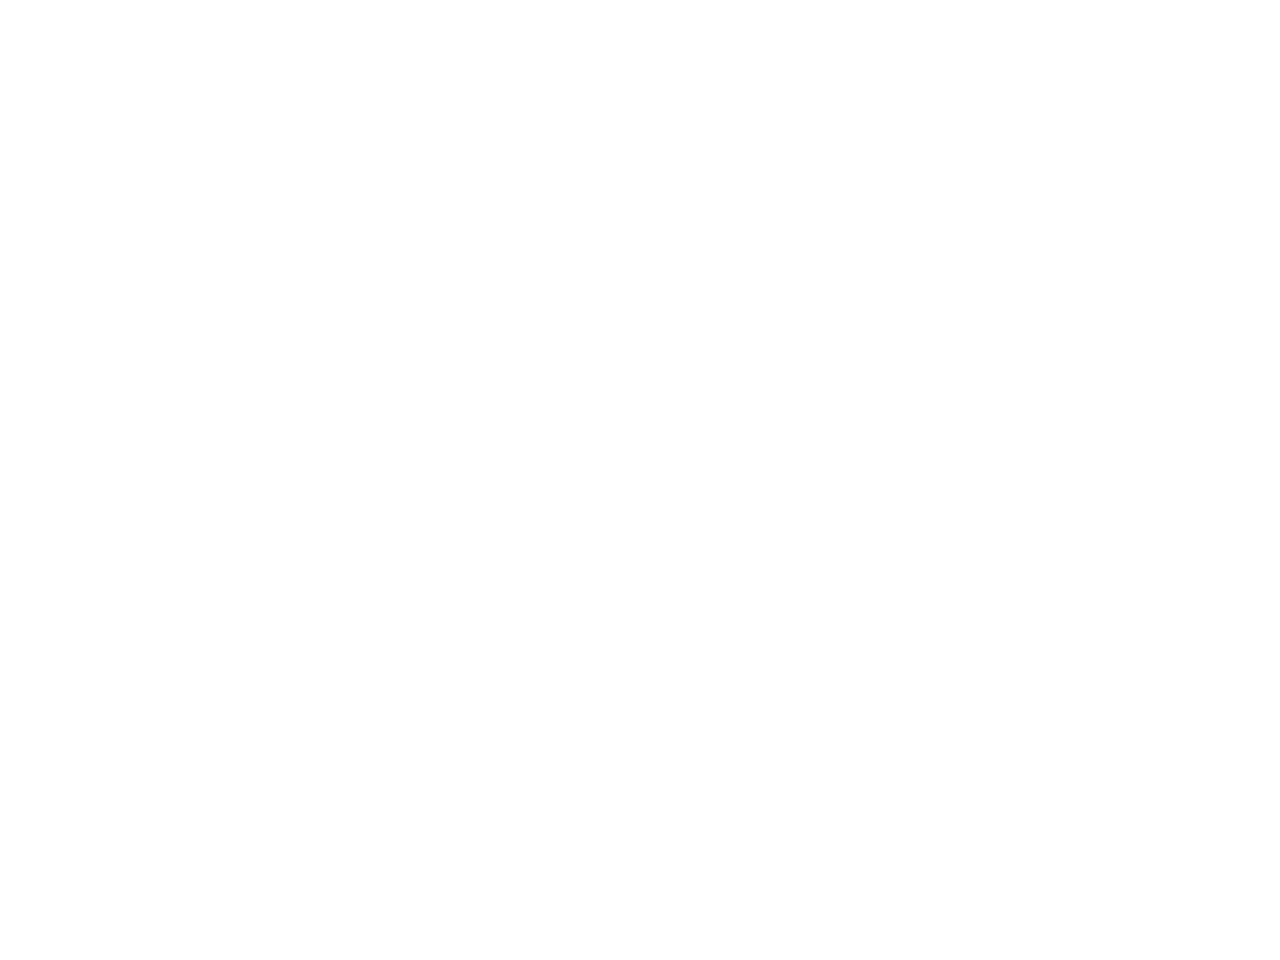

In [9]:
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(Points[:,0], Points[:,1], - sol, triangles = CList )
plt.show()

In [10]:
tgv = 10**14

S_tgv      = S.copy()
S_tgv      = S_tgv.tocoo()
S_tgv.row  = np.append( S_tgv.row, Dir )
S_tgv.col  = np.append( S_tgv.col, Dir )
S_tgv.data = np.append( S_tgv.data, np.ones_like( Dir ) *  - tgv )
S_tgv      = S_tgv.tocsr()

rhs_tgv = rhs.copy()
rhs_tgv[ Dir ] = np.zeros_like( Dir ) * tgv

t = time.time()
sol_tgv = sps.linalg.spsolve( - S_tgv, rhs_tgv )
print('Elapsed time %1.3f seconds.' % (time.time() - t))

np.linalg.norm( sol - sol_tgv ) / np.linalg.norm( sol )

Elapsed time 0.006 seconds.


1.8146208628548937e-15

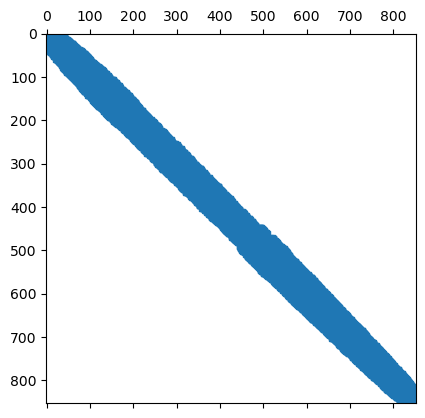

In [11]:
%matplotlib inline

plt.spy( S_, precision = 'present' )

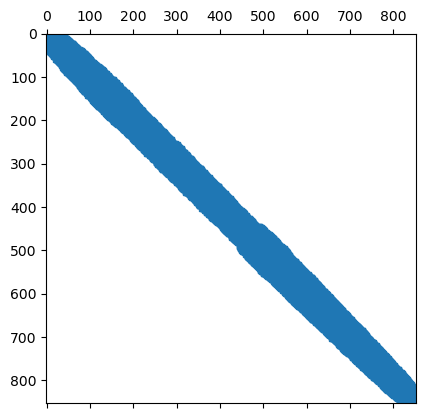

In [12]:
%matplotlib inline

plt.spy( S_tgv, precision = 'present' )

In [13]:
# now with grownups tools
from petsc4py import PETSc

solver_parameters = {
            "iterativeSolver"       : 'cg',
            "preconditioner"        : 'cholesky', # 'gamg' visit https://petsc.org/main/manualpages/PC/
            "relativeTolerance"     : 1e-8,
            "absoluteTolerance"     : 1e-8,
            "maximumIterations"     : 1e+2,
            "setInitialGuessNonzero": False,
            }


# build PETSc context
A = PETSc.Mat().createAIJ( size = ( Nv, Nv ), csr = ( S_tgv.indptr, S_tgv.indices, - S_tgv.data ) )
mixedPoisson = PETSc.KSP().create() # creating a KSP object
mixedPoisson.setOperators( A )
mixedPoisson.setType(                solver_parameters["iterativeSolver"       ] ) # decide iterative solver
mixedPoisson.getPC().setType(        solver_parameters["preconditioner"        ] ) # set preconditioner
mixedPoisson.setTolerances( rtol   = solver_parameters["relativeTolerance"     ], \
                            atol   = solver_parameters["absoluteTolerance"     ], \
                            max_it = solver_parameters["maximumIterations"     ] )
mixedPoisson.setInitialGuessNonzero( solver_parameters["setInitialGuessNonzero"] )

# initialize PETSc solution vector
solution        = PETSc.Vec().createSeq( Nv ) 
# initialize PETSc     rhs vector
righthandside   = PETSc.Vec().createSeq( Nv ) 
righthandside.setValues( range( Nv ), rhs_tgv )


t = time.time()
mixedPoisson.solve( righthandside, solution ) # A is implicit inside the context
print('Elapsed time %1.3f seconds.' % (time.time() - t))
sol_petsc = solution.getArray()


np.linalg.norm( sol - sol_petsc ) / np.linalg.norm( sol )

Elapsed time 0.003 seconds.


3.8810183223450165e-15